# **Part 1.1**

## **U.S. States Predictions**

### **Load Dataset**

In [22]:
import pandas as pd

dataset = pd.read_csv('datasets/final_dataset.csv', delimiter='\t')
dataset.head()

,Date,Date_index,State,Confirmed,Deaths,Cumulative Confirmed,Cumulative Deaths,State of Emergency Declared,Stay at home ordered,Gatherings banned,Out-of-state Travel Restrictions,Schools closed,Daycares Closed,Bars and Restaurants Closed,Non-essential retails closed,Lat,Long,Population,Area,Density
0,2020-01-22,1,Alabama,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,32.3182,-86.9023,4903185,135767,36.11
1,2020-01-23,2,Alabama,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,32.3182,-86.9023,4903185,135767,36.11
2,2020-01-24,3,Alabama,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,32.3182,-86.9023,4903185,135767,36.11
3,2020-01-25,4,Alabama,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,32.3182,-86.9023,4903185,135767,36.11
4,2020-01-26,5,Alabama,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,32.3182,-86.9023,4903185,135767,36.11


In [0]:
# List of columns to normalize
columns_to_norm = [ 'State of Emergency Declared', 'Stay at home ordered',
       'Gatherings banned', 'Out-of-state Travel Restrictions',
       'Schools closed', 'Daycares Closed', 'Bars and Restaurants Closed',
       'Non-essential retails closed', 'Lat', 'Long', 'Population', 'Area',
       'Density']
dataset[columns_to_norm] = (dataset[columns_to_norm] - dataset[columns_to_norm].mean())/(dataset[columns_to_norm].max()-dataset[columns_to_norm].min())

In [4]:
dataset.head() # Dataset preview after normalization

,Date,Date_index,State,Confirmed,Deaths,Cumulative Confirmed,Cumulative Deaths,State of Emergency Declared,Stay at home ordered,Gatherings banned,Out-of-state Travel Restrictions,Schools closed,Daycares Closed,Bars and Restaurants Closed,Non-essential retails closed,Lat,Long,Population,Area,Density
0,2020-01-22,1,Alabama,0.0,0.0,0.0,0.0,-0.447842,0.481674,-0.097376,-0.380113,-0.500542,-0.571893,-0.557146,-0.759054,-0.130317,0.004768,-0.034426,-0.029051,-0.027055
1,2020-01-23,2,Alabama,0.0,0.0,0.0,0.0,-0.447842,0.481674,-0.097376,-0.380113,-0.500542,-0.571893,-0.557146,-0.759054,-0.130317,0.004768,-0.034426,-0.029051,-0.027055
2,2020-01-24,3,Alabama,0.0,0.0,0.0,0.0,-0.447842,0.481674,-0.097376,-0.380113,-0.500542,-0.571893,-0.557146,-0.759054,-0.130317,0.004768,-0.034426,-0.029051,-0.027055
3,2020-01-25,4,Alabama,0.0,0.0,0.0,0.0,-0.447842,0.481674,-0.097376,-0.380113,-0.500542,-0.571893,-0.557146,-0.759054,-0.130317,0.004768,-0.034426,-0.029051,-0.027055
4,2020-01-26,5,Alabama,0.0,0.0,0.0,0.0,-0.447842,0.481674,-0.097376,-0.380113,-0.500542,-0.571893,-0.557146,-0.759054,-0.130317,0.004768,-0.034426,-0.029051,-0.027055


### **Global Confirmed Cases & Deaths Trend Visualization**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'Date')

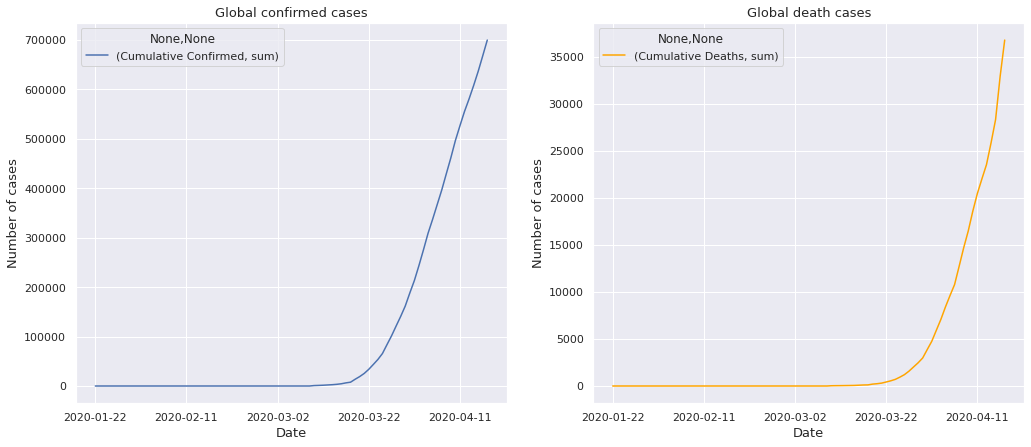

In [5]:
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
import seaborn as sns
sns.set()
# train = world_train[world_train['Country_Region']=='US']
# medCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = dataset.groupby(['Date']).agg({'Cumulative Confirmed':['sum']})
fatalities_total_date = dataset.groupby(['Date']).agg({'Cumulative Deaths':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
confirmed_total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global death cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

### **Regression**

#### **California Death and Confimed Cases Trend**

Text(0, 0.5, 'Deaths')

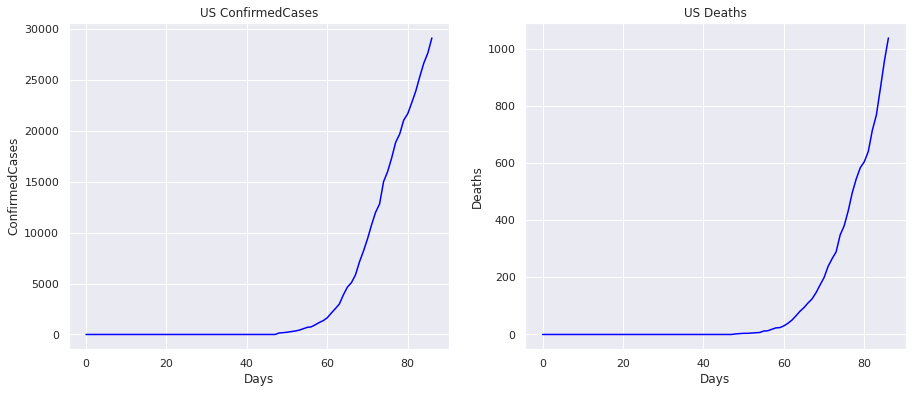

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

y1 = dataset[dataset['State']=='California'].sort_values(by=['Date'])['Cumulative Confirmed']
x1 = range(0, len(y1))
ax1.plot(x1, y1, color='blue')
ax1.set_title("California ConfirmedCases")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = dataset[dataset['State']=='California'].sort_values(by=['Date'])['Cumulative Deaths']
x2 = range(0, len(y2))
ax2.plot(x2, y2, color='blue')
ax2.set_title("California Deaths")
ax2.set_xlabel("Days")
ax2.set_ylabel("Deaths")

#### **Data Preparation**

In [0]:
def trendSet(dataset, add_col, timelimit):
  # new_dataset = pd.DataFrame(columns= list(dataset.columns)+['Death_1','Death_2','Death_3','Confirmed_1','Confirmed_2','Confirmed_3'])
  new_dataset = pd.DataFrame(columns= list(dataset.columns)+add_col)
  for index in range(dataset.shape[0]):
    row = dataset.iloc[index]
    if int(row['Date_index']) - timelimit > 0:
      trend = {}
      for i in range(1,timelimit+1):
        temp = dataset[dataset['Date_index']==int(row['Date_index'])-i]
        row['Death_'+str(i)]= temp['Cumulative Deaths'].values[0]
        row['Confirmed_'+str(i)]= temp['Cumulative Confirmed'].values[0]
      new_dataset.loc[index] = row
  return new_dataset


def addColumns(timelimit):
  add_col = []
  for i in range(1, timelimit+1):
    add_col.append("Death_"+str(i))
    add_col.append("Confirmed_"+str(i))
  return add_col

In [0]:
%precision 2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
encoder = LabelEncoder()
X_train={}
X_test={}
Y1_train={}
Y1_test={}
Y2_train={}
Y2_test={}
regressor1={}
regressor2={}
Y_pred1={}
Y_pred2={}
timelimit=3
for state in dataset.State.unique():
  dataSubSet = dataset[dataset['State']==state]
  dataSubSet.sort_values(by=['Date_index'],inplace=True)
  addCol = addColumns(timelimit)
  dataSubSet = trendSet(dataSubSet,addCol, timelimit)
  X_test[state] = dataSubSet[['State of Emergency Declared',
        'Stay at home ordered', 'Gatherings banned',
        'Out-of-state Travel Restrictions', 'Schools closed', 'Daycares Closed',
        'Bars and Restaurants Closed', 'Non-essential retails closed'] + addCol][dataSubSet['Date_index']>70]
  X_train[state] = dataSubSet[['State of Emergency Declared',
  'Stay at home ordered', 'Gatherings banned',
  'Out-of-state Travel Restrictions', 'Schools closed', 'Daycares Closed',
  'Bars and Restaurants Closed', 'Non-essential retails closed'] + addCol][dataSubSet['Date_index']<=70]
  Y1_train[state] = dataSubSet['Cumulative Confirmed'][dataSubSet['Date_index']<=70]
  Y1_test[state] = dataSubSet['Cumulative Confirmed'][dataSubSet['Date_index']>70]
  Y2_train[state] = dataSubSet[ 'Cumulative Deaths'][dataSubSet['Date_index']<=70]
  Y2_test[state] = dataSubSet[ 'Cumulative Deaths'][dataSubSet['Date_index']>70]

#### **Multiple Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

linear_rmse_confirmed ={}
linear_rmse_deaths ={}
linearRegressor1 ={}
linearRegressor2 ={}
Y_pred1_linear={}
Y_pred2_linear={}
for state in dataset.State.unique():
  linearRegressor1[state] = LinearRegression()
  linearRegressor2[state] = LinearRegression()
  linearRegressor1[state].fit(X_train[state],Y1_train[state])
  linearRegressor2[state].fit(X_train[state],Y2_train[state])
  Y_pred1_linear[state] = linearRegressor1[state].predict(X_test[state])
  Y_pred2_linear[state] = linearRegressor2[state].predict(X_test[state])
  linear_rmse_confirmed[state]=sqrt(mean_squared_error(Y1_test[state],Y_pred1_linear[state]))
  linear_rmse_deaths[state]=sqrt(mean_squared_error(Y2_test[state],Y_pred2_linear[state]))

##### **Validation results visualization**

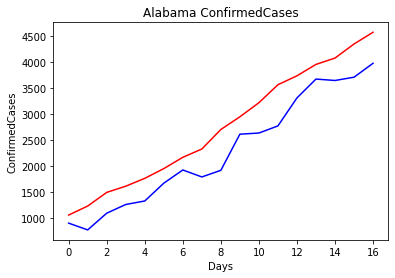

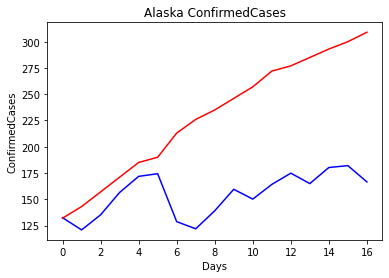

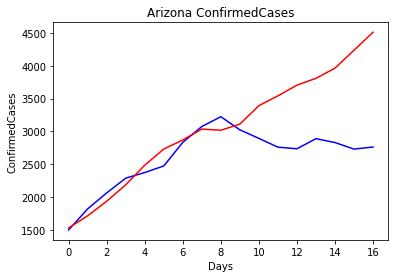

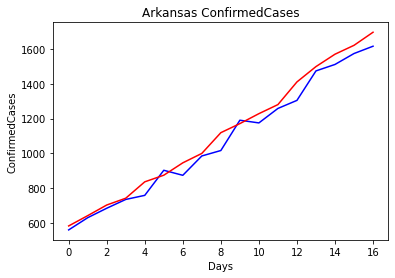

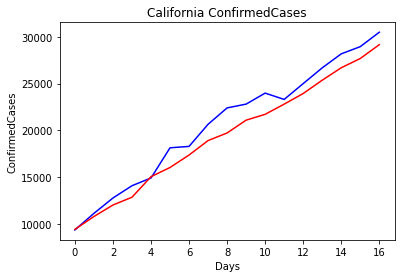

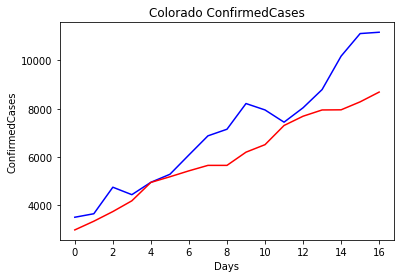

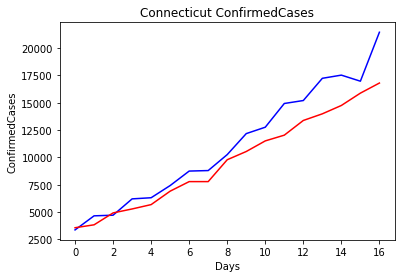

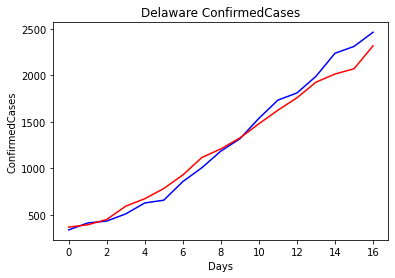

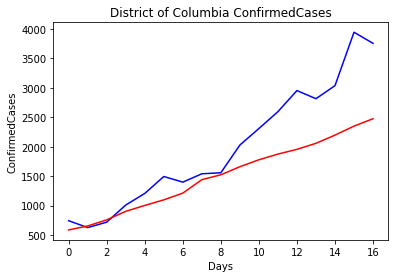

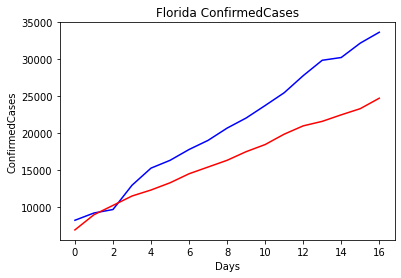

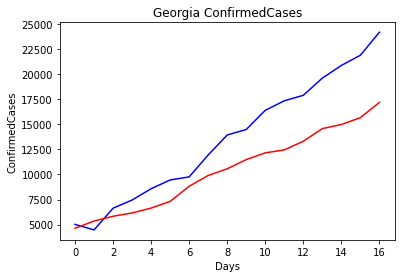

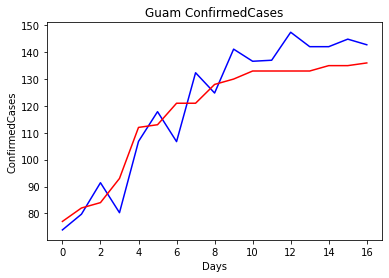

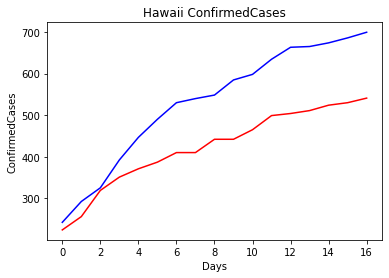

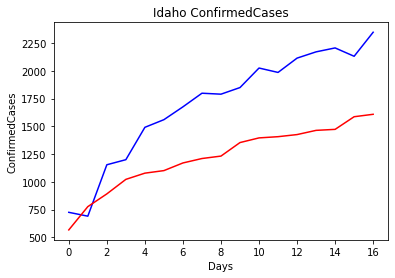

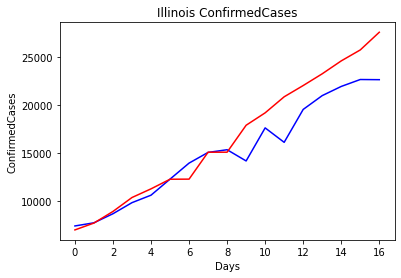

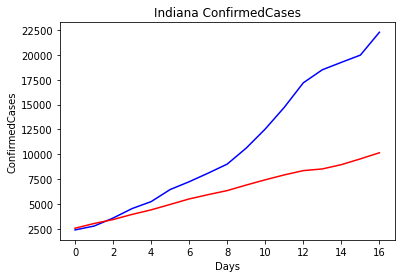

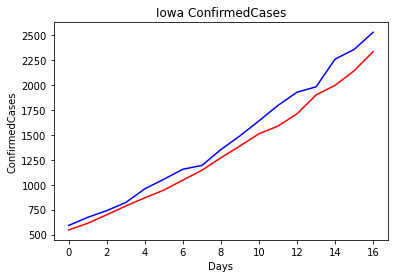

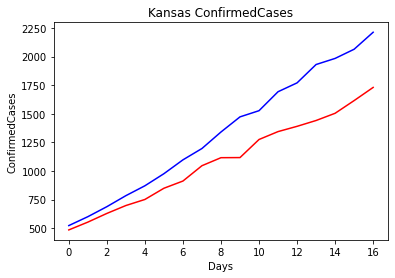

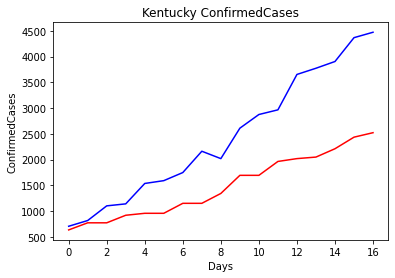

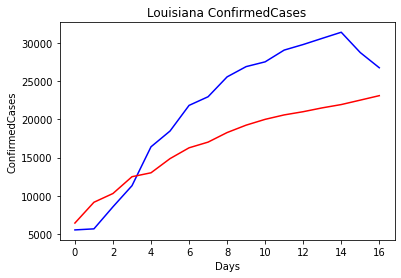

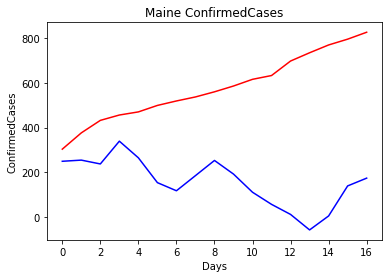

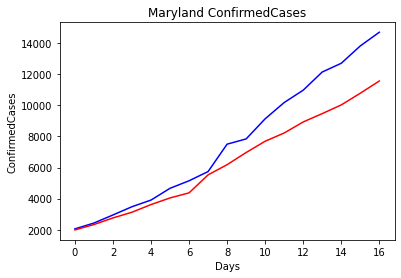

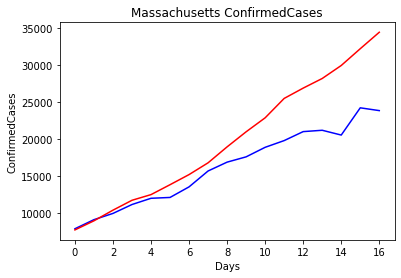

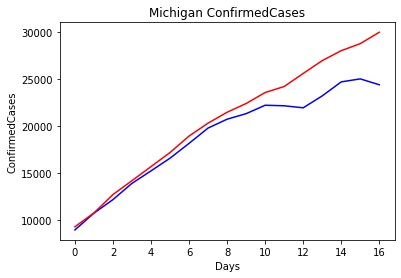

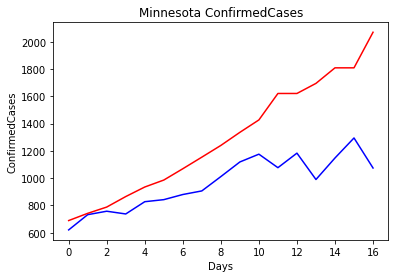

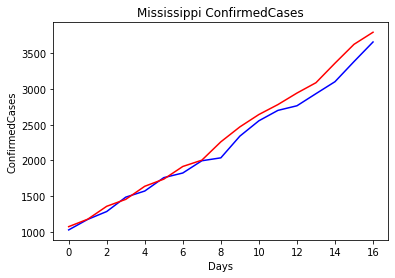

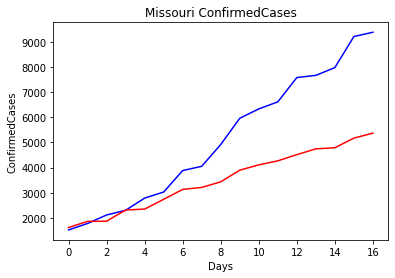

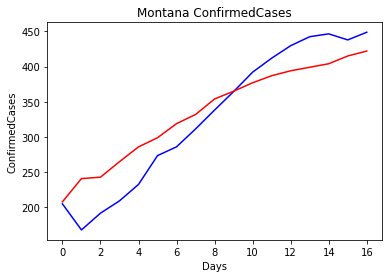

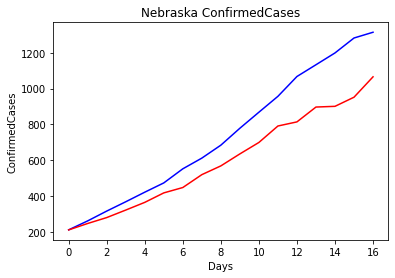

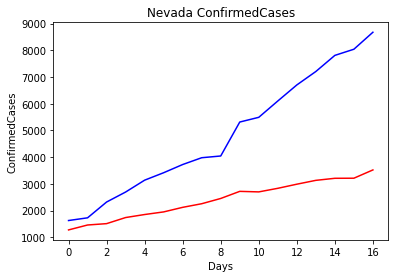

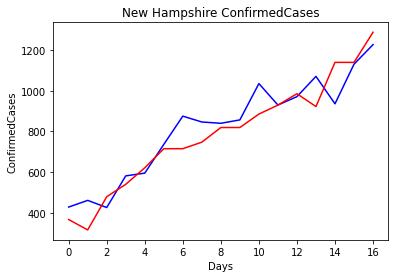

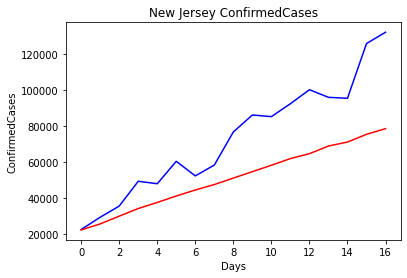

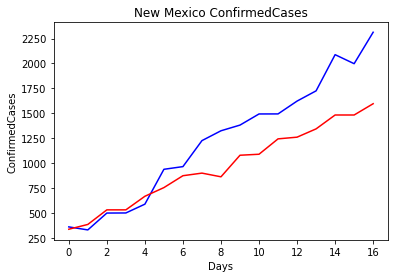

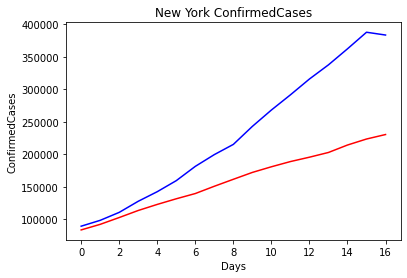

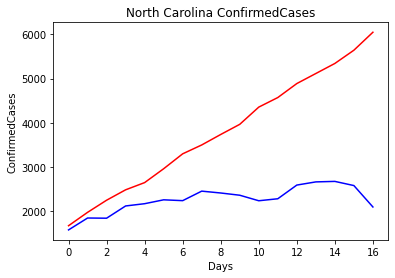

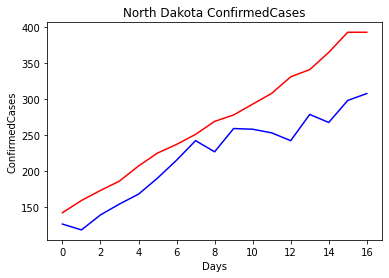

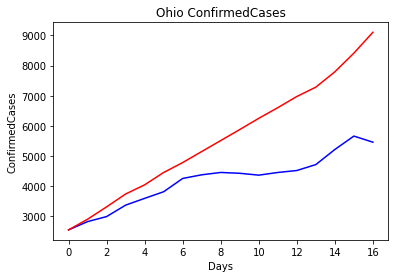

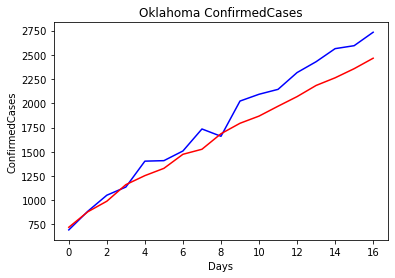

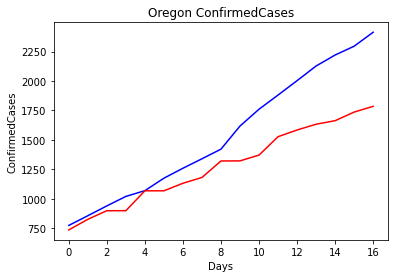

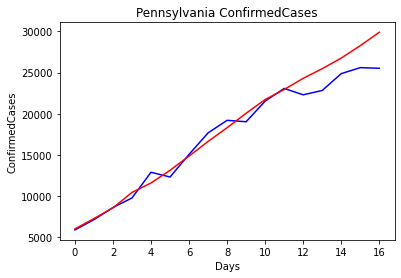

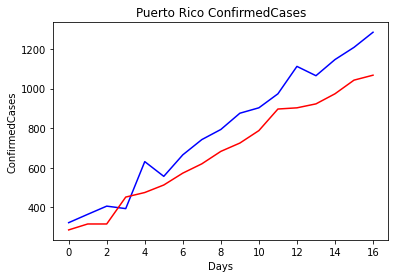

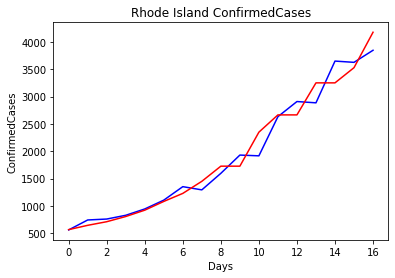

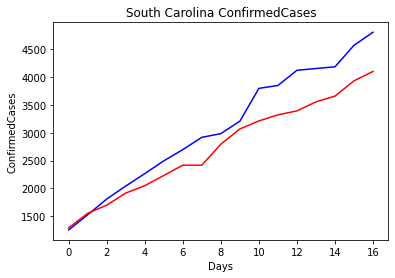

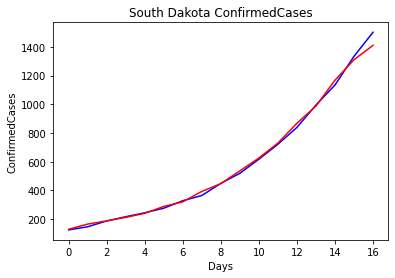

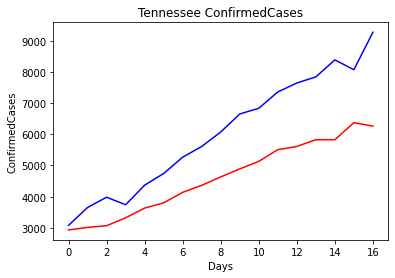

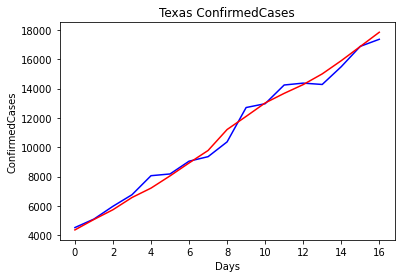

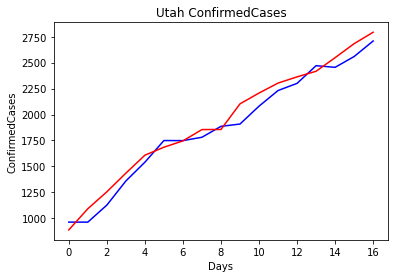

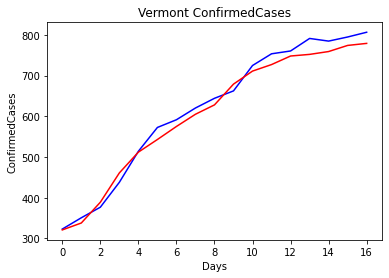

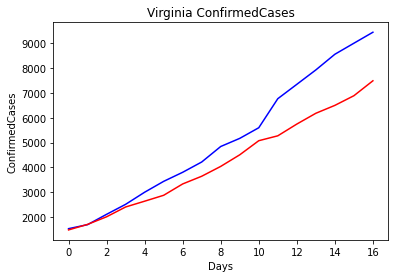

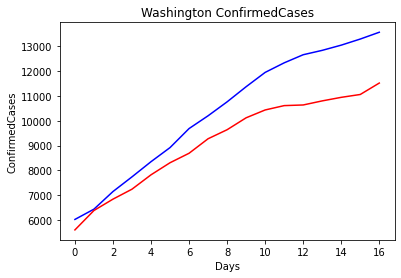

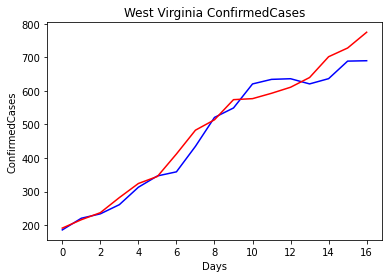

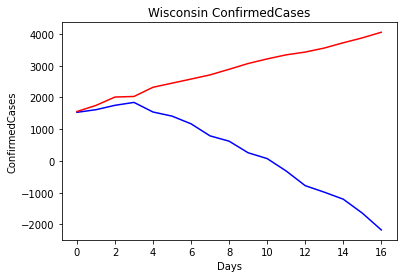

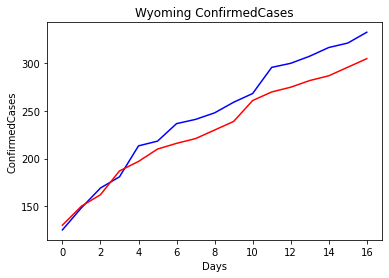

In [8]:
import matplotlib.pyplot as plt

for state in dataset.State.unique():
  x1=[i for i in range(len(Y1_test[state]))]
  x2=[i for i in range(len(Y_pred1_linear[state]))]
  plt.plot(x2, Y_pred1_linear[state], color='blue')
  plt.plot(x1, Y1_test[state], color='red')

  plt.title(f"{state} ConfirmedCases")
  plt.xlabel("Days")
  plt.ylabel("ConfirmedCases")
  plt.show()

##### **Average RMSE**

In [0]:
def avg_rmse(rmse_confirmed):
  sum=0
  count=0
  for i,j in rmse_confirmed.items():
    sum += j
    count +=1
  return sum/count
  

In [10]:
'ConfirmedCase avg. RMSE score: '+str(avg_rmse(linear_rmse_confirmed)), 'Deaths avg. RMSE score: '+str(avg_rmse(linear_rmse_deaths))

('ConfirmedCase avg. RMSE score: 3390.044152749916',
 'Deaths avg. RMSE score: 86.50892005555411')

#### **Support Vector Regression(SVR)**

In [0]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt
svrRegressor1={}
svrRegressor2={}
svr_rmse_confirmed ={}
svr_rmse_deaths ={}
Y_pred1_svr={}
Y_pred2_svr={}
for state in dataset.State.unique():
  svrRegressor1[state] = SVR(kernel='linear')
  svrRegressor2[state] = SVR(kernel='linear')
  svrRegressor1[state].fit(X_train[state],Y1_train[state])
  svrRegressor2[state].fit(X_train[state],Y2_train[state])
  Y_pred1_svr[state] = svrRegressor1[state].predict(X_test[state])
  Y_pred2_svr[state] = svrRegressor2[state].predict(X_test[state])
  svr_rmse_confirmed[state]=sqrt(mean_squared_error(Y1_test[state],Y_pred1_svr[state]))
  svr_rmse_deaths[state]=sqrt(mean_squared_error(Y2_test[state],Y_pred2_svr[state]))

##### **Validation results visualization**

In [12]:
import matplotlib.pyplot as plt

for state in dataset.State.unique():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

  x=[i for i in range(len(Y1_test[state]))]
  ax1.plot(x, Y_pred1_svr[state], color='blue')
  ax1.plot(x, Y1_test[state], color='red')
  ax1.set_title(f"{state} ConfirmedCases")
  ax1.set_xlabel("Days")
  ax1.set_ylabel("ConfirmedCases")

  ax2.plot(x, Y_pred2_svr[state], color='blue')
  ax2.plot(x, Y2_test[state], color='red')
  ax2.set_title(f"{state} Deaths")
  ax2.set_xlabel("Days")
  ax2.set_ylabel("Deaths")

Output hidden; open in https://colab.research.google.com to view.

##### **Average RMSE**

In [13]:
'ConfirmedCase avg. RMSE score: '+str(avg_rmse(svr_rmse_confirmed)), 'Deaths avg. RMSE score: '+str(avg_rmse(svr_rmse_deaths))

('ConfirmedCase avg. RMSE score: 2457.0288950715276',
 'Deaths avg. RMSE score: 176.69862266407955')

#### **Best Evaluation results of 4 states**

In [0]:
listOfStates = ['California', 'Texas', 'South Dakota', 'Pennsylvania']

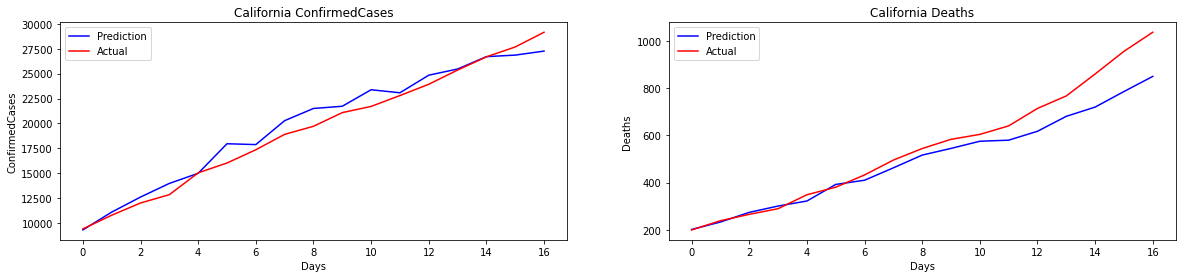

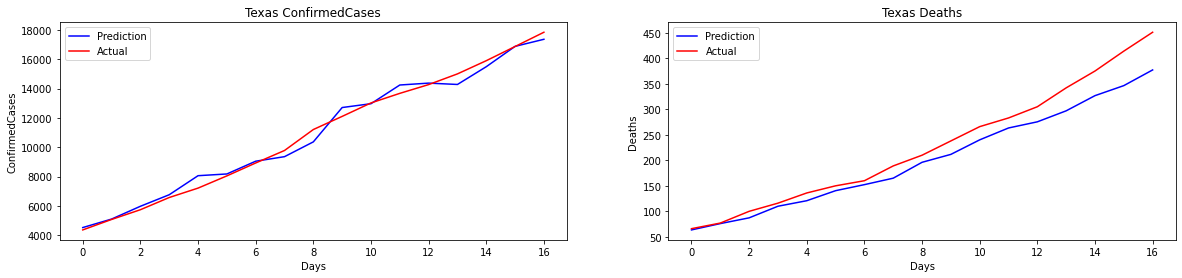

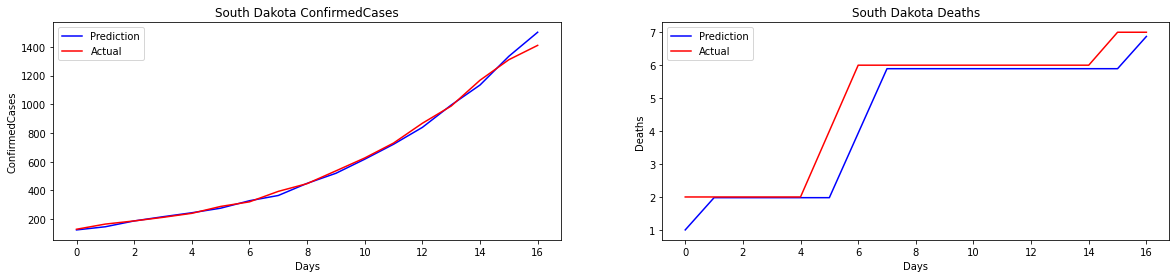

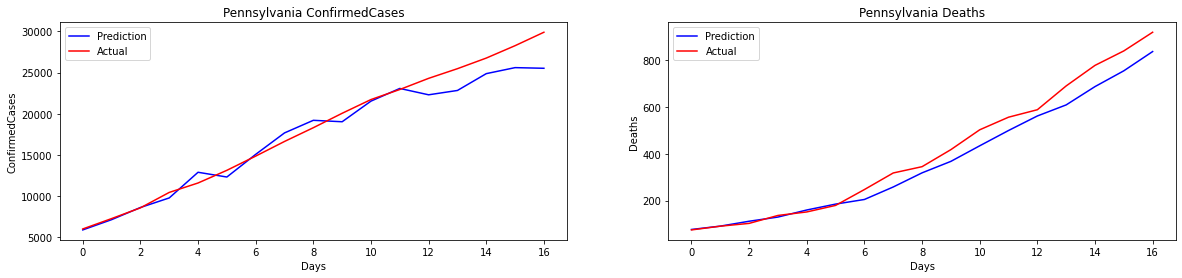

In [17]:
for state in listOfStates:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))

  x=[i for i in range(len(Y1_test[state]))]
  if svr_rmse_confirmed[state] < linear_rmse_confirmed[state]:
    ax1.plot(x, Y_pred1_svr[state], color='blue')
  else:
    ax1.plot(x, Y_pred1_linear[state], color='blue')
  
  if svr_rmse_deaths[state] < linear_rmse_deaths[state]:
    ax2.plot(x, Y_pred2_svr[state], color='blue')
  else:
    ax2.plot(x, Y_pred2_linear[state], color='blue')
      
  ax1.plot(x, Y1_test[state], color='red')
  ax1.set_title(f"{state} ConfirmedCases")
  ax1.set_xlabel("Days")
  ax1.set_ylabel("ConfirmedCases")
  ax1.legend(['Prediction', 'Actual'])

  ax2.plot(x, Y2_test[state], color='red')
  ax2.set_title(f"{state} Deaths")
  ax2.set_xlabel("Days")
  ax2.set_ylabel("Deaths")
  ax2.legend(['Prediction', 'Actual'])


#### **Predictions for California and Texas till 15th May**

In [0]:
prediction_dataset = dataset.copy()

In [0]:
from dateutil import parser
from datetime import datetime, timedelta

def prepareX(dataset, state, addCol, date):
  X = pd.DataFrame(columns= list(dataset.columns)+addCol)
  date = parser.parse(date)
  endDate = date - timedelta(days=1)
  X = dataset.query("Date=='"+ endDate.strftime("%Y-%m-%d") + "' and State=='"+ state+"'").copy()
  X['Date']= date.strftime("%Y-%m-%d")
  # print(X)
  for days in range(1,4):
    temp = date - timedelta(days=days)
    row = dataset.query("Date=='"+ temp.strftime("%Y-%m-%d") + "' and State=='"+ state+"'")
    X['Death_'+str(days)]= row['Cumulative Deaths'].values[0]
    X['Confirmed_'+str(days)]= row['Cumulative Confirmed'].values[0]
    # new_dataset.loc[index] = row
  # print(X.columns)
  return X

In [0]:
def predict(dataset, state, regressor1, regressor2, timelimit, start_date, end_date):
  local_dataset = dataset.copy()
  addCol = addColumns(timelimit)
  columns_to_consider = ['State of Emergency Declared',
        'Stay at home ordered', 'Gatherings banned',
        'Out-of-state Travel Restrictions', 'Schools closed', 'Daycares Closed',
        'Bars and Restaurants Closed', 'Non-essential retails closed']+addCol
  startdate = parser.parse(start_date)
  enddate = parser.parse(end_date)
  days = (enddate-startdate).days
  for i in range(days):
    tmpDate = startdate + timedelta(days=i)
    X = prepareX(local_dataset, state, addCol, tmpDate.strftime("%Y-%m-%d"))
    # print(X)
    cases = regressor1[state].predict(X[columns_to_consider])
    death = regressor2[state].predict(X[columns_to_consider])
    X['Cumulative Confirmed']= cases
    X['Cumulative Deaths'] = death
    local_dataset = local_dataset.append(X)
  return local_dataset


In [0]:
pr={}
for state in listOfStates:
  pr[state] = predict(prediction_dataset, state, svrRegressor1, svrRegressor2, timelimit, '2020-04-18', '2020-05-17')

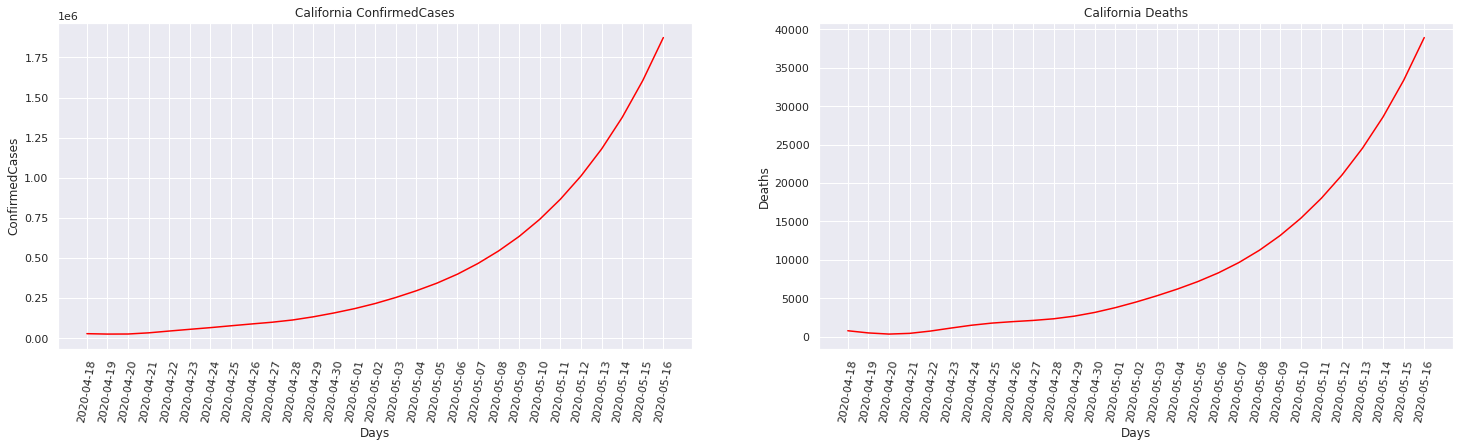

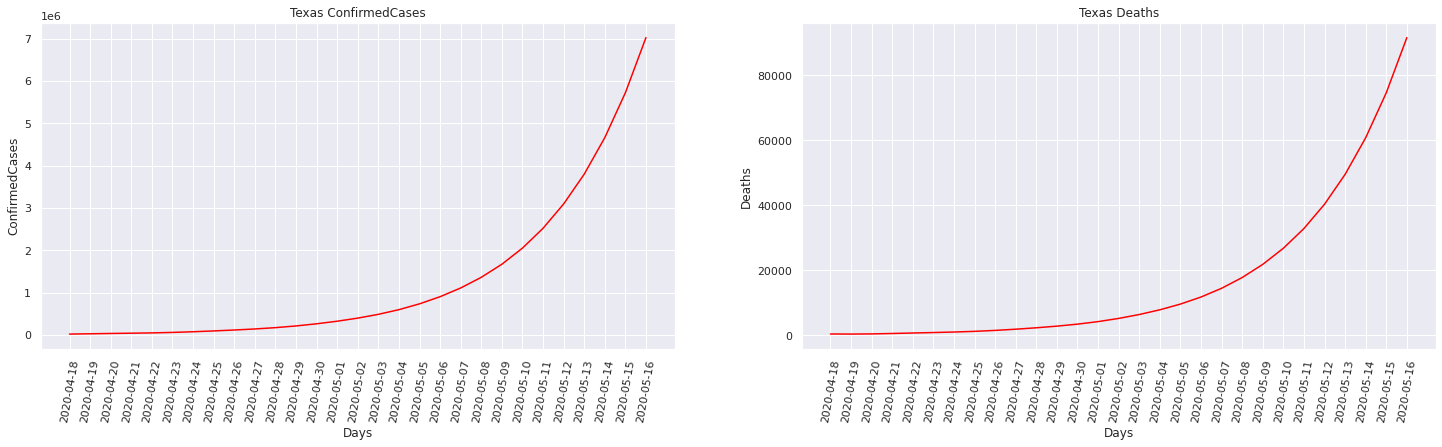

In [42]:
listOfStates = ['California', 'Texas']
for state in listOfStates:
  data = pr[state].query("Date>='2020-04-18' and State=='"+state+"'")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,6))
  # x=[i for i in range(data.shape[0])]

  ax1.plot(data['Date'], data['Cumulative Confirmed'], color='red')
  ax1.set_title(f"{state} ConfirmedCases")
  ax1.set_xlabel("Days")
  ax1.xaxis.set_tick_params(rotation=80)
  ax1.set_ylabel("ConfirmedCases")

  ax2.plot(data['Date'], data['Cumulative Deaths'], color='red')
  ax2.set_title(f"{state} Deaths")
  ax2.set_xlabel("Days")
  ax2.xaxis.set_tick_params(rotation=80)
  ax2.set_ylabel("Deaths")


# **Part 1.2**

## ***U.S. Predictions using Deep Learning***

### **Data Preparation for LSTM**

In [23]:
dataset.describe()

,Date_index,Confirmed,Deaths,Cumulative Confirmed,Cumulative Deaths,State of Emergency Declared,Stay at home ordered,Gatherings banned,Out-of-state Travel Restrictions,Schools closed,Daycares Closed,Bars and Restaurants Closed,Non-essential retails closed,Lat,Long,Population,Area,Density
count,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4611.000000,4.611000e+03,4.611000e+03,4611.000000
mean,44.000000,151.700282,7.974192,1926.038170,68.729126,0.447842,0.518326,1.947517,7.602255,0.500542,0.571893,0.557146,0.759054,38.563817,-88.343698,6.257735e+06,1.858262e+05,143.972642
std,25.115801,721.810996,72.958348,11240.013777,556.162569,0.497326,0.499718,4.365644,9.559320,0.500054,0.494858,0.496777,0.427704,7.441217,37.546640,7.213414e+06,2.464164e+05,539.108659
min,1.000000,-112.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.444300,-157.498300,1.657180e+05,1.770000e+02,0.420000
25%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.565300,-99.784000,1.787147e+06,8.293300e+04,21.360000
50%,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,39.318500,-88.986100,4.217737e+06,1.412970e+05,39.870000
75%,66.000000,34.000000,1.000000,323.500000,5.000000,1.000000,1.000000,3.000000,20.000000,1.000000,1.000000,1.000000,1.000000,42.756000,-77.209800,7.278717e+06,2.164430e+05,93.200000
max,87.000000,11434.000000,3215.000000,230597.000000,17131.000000,1.000000,1.000000,20.000000,20.000000,1.000000,1.000000,1.000000,1.000000,61.370700,144.793700,3.951222e+07,1.723337e+06,3987.280000


In [24]:
trainSet = dataset.query("Date_index<=70and Date_index<=70")
validationSet = dataset.query("Date_index>70and Date_index>70")
print(trainSet.shape, validationSet.shape)

(3710, 20) (901, 20)


In [0]:
# train_df = Alabama_dataset.query("Date>='2020/01/22'and Date<='2020/04/03'")
%precision 2
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

def createDataSet(train_df, days_in_sequence):
  # train_df = dataset.query("Date>='"+startDate+"'and Date<='"+endDate+"'")
  # days_in_sequence = 10
  trend_list = []

  for province in tqdm(train_df.State.unique()):
      province_df = train_df.query(f"State=='{province}'")

      for i in range(0,len(province_df),int(days_in_sequence/2)):
          if i+days_in_sequence<=len(province_df):
              infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1]['Cumulative Confirmed'].values]
              fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1]['Cumulative Deaths'].values]
              state_of_emer = [float(x) for x in province_df[i:i+days_in_sequence-1]['State of Emergency Declared'].values]
              stay_at_home = [float(x) for x in province_df[i:i+days_in_sequence-1]['Stay at home ordered'].values]
              gathering_banned = [float(x) for x in province_df[i:i+days_in_sequence-1]['Gatherings banned'].values]
              out_of_state = [float(x) for x in province_df[i:i+days_in_sequence-1]['Out-of-state Travel Restrictions'].values]
              school_closed = [float(x) for x in province_df[i:i+days_in_sequence-1]['Schools closed'].values]
              daycares = [float(x) for x in province_df[i:i+days_in_sequence-1]['Daycares Closed'].values]
              bars_and_rest = [float(x) for x in province_df[i:i+days_in_sequence-1]['Bars and Restaurants Closed'].values]
              non_ess = [float(x) for x in province_df[i:i+days_in_sequence-1]['Non-essential retails closed'].values]

              #preparing all the demographic inputs
              latitude = float(province_df.iloc[i].Lat)/ max(train_df.Lat)
              longitude = float(province_df.iloc[i].Long)/ max(train_df.Long)
              density = float(province_df.iloc[i].Density) / max(train_df.Density)
              population = float(province_df.iloc[i].Population) / max(train_df.Population)
              Area = float(province_df.iloc[i].Area) / max(train_df.Area)

              expected_cases = float(province_df.iloc[i+days_in_sequence-1]['Cumulative Confirmed'])
              expected_fatalities = float(province_df.iloc[i+days_in_sequence-1]['Cumulative Deaths'])

              trend_list.append({
                                "infection_trend":infection_trend,
                                "fatality_trend":fatality_trend,
                                "state_of_emer":state_of_emer,
                                "stay_at_home":stay_at_home,
                                "gathering_banned":gathering_banned,
                                "out_of_state":out_of_state,
                                "school_closed":school_closed,
                                "daycares":daycares,
                                "bars_and_rest":bars_and_rest,
                                "non_ess":non_ess,
                                "Static_Params":[latitude, longitude, density, population, Area],
                                "expected_cases":expected_cases,
                                "expected_fatalities":expected_fatalities})
  trend_df = pd.DataFrame(trend_list)
  trend_df["lstm_input"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"], trends["state_of_emer"],trends["stay_at_home"],trends["gathering_banned"],trends["out_of_state"],trends["school_closed"],trends["daycares"],trends["bars_and_rest"],trends["non_ess"]]) for idx,trends in trend_df.iterrows()]
  i=0
  temp_df = pd.DataFrame()
  for idx,row in trend_df.iterrows():
      if sum(row.infection_trend)>0:
          temp_df = temp_df.append(row)
      else:
          if i<20:
              temp_df = temp_df.append(row)
              i+=1
  trend_df = temp_df
  return trend_df
  # pbar.update(1)

### **Train and Test Data Split**

In [34]:
sequence_length=10
train_trend_df = createDataSet(trainSet, sequence_length)
train_trend_df = shuffle(train_trend_df)
validation_trend_df = createDataSet(validationSet, sequence_length)
print(train_trend_df.shape, validation_trend_df.shape)

100%|██████████| 53/53 [00:00<00:00, 62.77it/s]


(268, 14) (106, 14)


In [0]:
def createInOut(trend_df):
  X_temp = np.array([trend_df['lstm_input'].values[i] for i in range(trend_df.shape[0])])
  X_demo = np.array([trend_df['Static_Params'].values[i] for i in range(trend_df.shape[0])])
  Y1 = trend_df['expected_cases'].values
  Y2 = trend_df['expected_fatalities'].values
  return X_temp, X_demo, Y1, Y2

In [38]:
X_train_temp, X_train_demo, Y1_train, Y2_train = createInOut(train_trend_df)
X_valid_temp, X_valid_demo, Y1_valid, Y2_valid = createInOut(validation_trend_df)
print(X_train_temp.shape, X_valid_temp.shape)

(268, 10, 9) (106, 10, 9)


### **Model Architecture**

In [47]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# sequence_length=9
#temporal input branch
temporal_input_layer = layers.Input(shape=(10,sequence_length-1))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.5)(temporal_input_layer)
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.5)(main_rnn_layer)

demographic_input_layer = layers.Input(shape=(5))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.5)(demographic_dense)

rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(256)(merge_c)
dropout_c = layers.Dropout(0.5)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)


rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(256)(merge_f)
dropout_f = layers.Dropout(0.5)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="fatalities")(dropout_f)

model = Model([temporal_input_layer, demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10, 9)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 10, 64)       18944       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 10, 64)       33024       lstm_7[0][0]                     
____________________________________________________________________________________________

In [0]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [49]:
history = model.fit([X_train_temp,X_train_demo], [Y1_train, Y2_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_valid_temp,X_valid_demo],  [Y1_valid, Y2_valid]), 
          callbacks=callbacks)

Epoch 1/250
17/17 [==============================] - 4s 219ms/step - loss: 19.4356 - cases_loss: 16.7304 - fatalities_loss: 2.7052 - val_loss: 46.4520 - val_cases_loss: 35.5111 - val_fatalities_loss: 10.9409 - lr: 0.0010
Epoch 2/250
17/17 [==============================] - 2s 122ms/step - loss: 11.1350 - cases_loss: 8.9263 - fatalities_loss: 2.2087 - val_loss: 38.8702 - val_cases_loss: 26.5108 - val_fatalities_loss: 12.3594 - lr: 0.0010
Epoch 3/250
17/17 [==============================] - 2s 121ms/step - loss: 8.1518 - cases_loss: 6.4593 - fatalities_loss: 1.6925 - val_loss: 31.5974 - val_cases_loss: 22.6686 - val_fatalities_loss: 8.9289 - lr: 0.0010
Epoch 4/250
17/17 [==============================] - 2s 109ms/step - loss: 6.6058 - cases_loss: 5.3515 - fatalities_loss: 1.2542 - val_loss: 27.6244 - val_cases_loss: 20.3085 - val_fatalities_loss: 7.3159 - lr: 0.0010
Epoch 5/250
17/17 [==============================] - 2s 110ms/step - loss: 5.4472 - cases_loss: 4.5964 - fatalities_loss: 0

### **Model Loss**

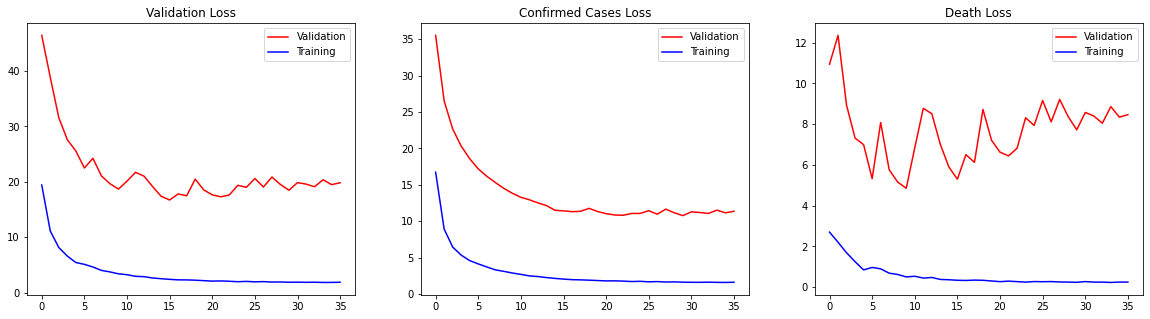

In [50]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(20, 5)
ax1.plot(history.epoch, history.history['val_loss'], color='red')
ax1.plot(history.epoch, history.history['loss'], color='blue')
ax1.set_title('Validation Loss')
ax1.legend(['Validation','Training'], loc='best')

ax2.plot(history.epoch, history.history['val_cases_loss'], color='red')
ax2.plot(history.epoch, history.history['cases_loss'], color='blue')
ax2.set_title('Confirmed Cases Loss')
ax2.legend(['Validation','Training'], loc='best')

ax3.plot(history.epoch, history.history['val_fatalities_loss'], color='red')
ax3.plot(history.epoch, history.history['fatalities_loss'], color='blue')
ax3.set_title('Death Loss')
ax3.legend(['Validation','Training'], loc='best')

plt.show()

### **RMSE**

In [0]:
Y1_pred, Y2_pred = model.predict([X_valid_temp,X_valid_demo])

In [0]:
Y1_pred = Y1_pred.reshape(-1)
Y2_pred = Y2_pred.reshape(-1)

In [55]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(Y1_valid, Y1_pred)), sqrt(mean_squared_error(Y2_valid, Y2_pred)))

29621.337732333708 1454.3417820602015


### **Predictions**

In [58]:
result = pd.DataFrame(columns=['Actual Confirmed Cases','Predicted Confirmed Cases','Actual Death Cases','Predicted Death Cases'])
result['Actual Confirmed Cases']=Y1_valid
result['Predicted Confirmed Cases']=Y1_pred
result['Actual Death Cases']=Y2_valid
result['Predicted Death Cases']=Y2_pred
result.reset_index(inplace=True, drop=True)
result.head(10)

,Actual Confirmed Cases,Predicted Confirmed Cases,Actual Death Cases,Predicted Death Cases
0,2947.0,208.730789,80.0,44.730225
1,4075.0,208.652695,118.0,43.475063
2,246.0,189.424652,7.0,2.810520
3,293.0,30.858379,9.0,-0.139600
4,3112.0,208.488510,97.0,8.739188
5,3964.0,103.487175,142.0,1.643626
6,1171.0,208.527512,21.0,16.572701
7,1569.0,100.954910,33.0,1.282591
8,21081.0,213.655655,583.0,42.540451
9,26686.0,89.030212,860.0,2.249673


In [0]:
# sequence_length=9
def build_inputs_for_date(province, date, df):
    start_date = date - timedelta(days=sequence_length-1)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    print(province)
    print(str_start_date)
    print(str_end_date)
    df = df.query("State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    print(df)


    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([df["Cumulative Confirmed"],
                                                 df["Cumulative Deaths"],
                                                 df["State of Emergency Declared"],
                                                 df["Stay at home ordered"],
                                                 df["Gatherings banned"],
                                                 df["Out-of-state Travel Restrictions"],
                                                 df["Schools closed"],
                                                 df["Daycares Closed"],
                                                 df["Bars and Restaurants Closed"],
                                                 df["Non-essential retails closed"]]),
                                     (10,sequence_length-1)), (1,0) ).astype(np.float32)
    i = -1
    province_df = df
    #preparing all the demographic inputs
    latitude = float(province_df.iloc[i].Lat)
    longitude = float(province_df.iloc[i].Long)
    density = float(province_df.iloc[i].Density)
    population = float(province_df.iloc[i].Population)
    Area = float(province_df.iloc[i].Area)
    demographic_input_data = [latitude, longitude, density, population, Area]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [0]:
def predict_for_region(province, df):
    begin_prediction = "2020-04-18"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-14"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(province, date, df)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        

        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "State of Emergency Declared": 1 if any(input_data[0][0][2]) else 0,
                        "Stay at home ordered": 1 if any(input_data[0][0][3]) else 0,
                        "Gatherings banned": 1 if any(input_data[0][0][4]) else 0,
                        "Out-of-state Travel Restrictions": 1 if any(input_data[0][0][5]) else 0,
                        "Schools closed": 1 if any(input_data[0][0][6]) else 0,
                        "Daycares Closed": 1 if any(input_data[0][0][7]) else 0,
                        "Bars and Restaurants Closed": 1 if any(input_data[0][0][8]) else 0,
                        "Non-essential retails closed": 1 if any(input_data[0][0][9]) else 0,
                        "latitude": input_data[1][0],
                        "longitude": input_data[1][0][1],
                        "density": input_data[1][0][2],
                        "population": input_data[1][0][3],
                        "Area": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=False)
    return df

In [85]:
dataset['Date'].max()

'2020-04-17'

In [0]:
# train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
from datetime import datetime
from datetime import timedelta
copy_df = dataset.query("Date>'2020-01-23'and Date<'2020-05-01'")
with tqdm(total=len(list(copy_df.State.unique()))) as pbar:
        for province in copy_df.State.unique():
            copy_df = predict_for_region(province, copy_df)
        pbar.update(1)

# **Part 2**

## **Global Predictions**

In [88]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Dataset-1**

In [89]:
dataset = gpd.read_file("datasets/train.csv")
dataset["ConfirmedCases"] = dataset["ConfirmedCases"].astype("float")
dataset["Fatalities"] = dataset["Fatalities"].astype("float")
dataset["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in dataset.iterrows()]
dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry
0,1,,Afghanistan,2020-01-22,0.0,0.0,None
1,2,,Afghanistan,2020-01-23,0.0,0.0,None
2,3,,Afghanistan,2020-01-24,0.0,0.0,None
3,4,,Afghanistan,2020-01-25,0.0,0.0,None
4,5,,Afghanistan,2020-01-26,0.0,0.0,None


### **Dataset-2**

In [90]:
enhanced_dataset = gpd.read_file("datasets/enhanced_covid_19.csv")
enhanced_dataset["Country_Region"] = [country_name.replace("'","") for country_name in enhanced_dataset["Country_Region"]]
# enhanced_dataset["restrictions"] = enhanced_dataset["restrictions"].astype("int")
enhanced_dataset["quarantine"] = enhanced_dataset["quarantine"].astype("int")
enhanced_dataset["schools"] = enhanced_dataset["schools"].astype("int")
enhanced_dataset["total_pop"] = enhanced_dataset["total_pop"].astype("float")
enhanced_dataset["density"] = enhanced_dataset["density"].astype("float")
enhanced_dataset["hospibed"] = enhanced_dataset["hospibed"].astype("float")
enhanced_dataset["lung"] = enhanced_dataset["lung"].astype("float")
enhanced_dataset["smokers_perc"] = enhanced_dataset["smokers_perc"].astype("float")
enhanced_dataset["smokers_perc"] = enhanced_dataset["smokers_perc"]/100.0
enhanced_dataset["total_pop"] = enhanced_dataset["total_pop"]/max(enhanced_dataset["total_pop"])
enhanced_dataset["density"] = enhanced_dataset["density"]/max(enhanced_dataset["density"])
enhanced_dataset["hospibed"] = enhanced_dataset["hospibed"]/max(enhanced_dataset["hospibed"])
enhanced_dataset["lung"] = enhanced_dataset["lung"]/max(enhanced_dataset["lung"])
enhanced_dataset["age_100+"] = enhanced_dataset["age_100+"].astype("float")
enhanced_dataset["age_100+"] = enhanced_dataset["age_100+"]/max(enhanced_dataset["age_100+"])
enhanced_dataset = enhanced_dataset[["Country_Region","Date","quarantine","schools","hospibed","lung","total_pop","density","age_100+", "smokers_perc"]]
enhanced_dataset.head()

,Country_Region,Date,quarantine,schools,hospibed,lung,total_pop,density,age_100+,smokers_perc
0,Afghanistan,2020-01-22,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
1,Afghanistan,2020-01-23,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
2,Afghanistan,2020-01-24,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
3,Afghanistan,2020-01-25,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
4,Afghanistan,2020-01-26,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894


### **Merge Dataset**

In [91]:
merge_dataset = dataset.merge(enhanced_dataset,how="left", on=["Country_Region","Date"]).drop_duplicates()
merge_dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,quarantine,schools,hospibed,lung,total_pop,density,age_100+,smokers_perc
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894


### **Replace Null Values**

In [0]:
for country_region in merge_dataset.Country_Region.unique():
    query_df = merge_dataset.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    # merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"smokers_perc"] = query_df.smokers_perc.values[0]

In [93]:

median_pop = np.median(enhanced_dataset.total_pop)
median_hospibed = np.median(enhanced_dataset.hospibed)
median_density = np.median(enhanced_dataset.density)
median_lung = np.median(enhanced_dataset.lung)
median_centenarian_pop = np.median(enhanced_dataset["age_100+"])
median_smokers_perc = np.median(enhanced_dataset["smokers_perc"])
#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in merge_dataset.Country_Region.unique():
    if enhanced_dataset.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"total_pop"] = median_pop
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"hospibed"] = median_hospibed
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"density"] = median_density
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"lung"] = median_lung
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        # merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"restrictions"] = 0
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"quarantine"] = 0
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"schools"] = 0
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"smokers_perc"] = median_smokers_perc

The missing countries/region are:
Australia_Australian Capital Territory
Australia_New South Wales
Australia_Northern Territory
Australia_Queensland
Australia_South Australia
Australia_Tasmania
Australia_Victoria
Australia_Western Australia
Canada_Alberta
Canada_British Columbia
Canada_Manitoba
Canada_New Brunswick
Canada_Newfoundland and Labrador
Canada_Northwest Territories
Canada_Nova Scotia
Canada_Ontario
Canada_Prince Edward Island
Canada_Quebec
Canada_Saskatchewan
Canada_Yukon
China_Anhui
China_Beijing
China_Chongqing
China_Fujian
China_Gansu
China_Guangdong
China_Guangxi
China_Guizhou
China_Hainan
China_Hebei
China_Heilongjiang
China_Henan
China_Hong Kong
China_Hubei
China_Hunan
China_Inner Mongolia
China_Jiangsu
China_Jiangxi
China_Jilin
China_Liaoning
China_Macau
China_Ningxia
China_Qinghai
China_Shaanxi
China_Shandong
China_Shanghai
China_Shanxi
China_Sichuan
China_Tianjin
China_Tibet
China_Xinjiang
China_Yunnan
China_Zhejiang
Denmark_Faroe Islands
Denmark_Greenland
France_Fr

### **Data Preparation**

In [0]:
#Makes it easier to generate the sequences
def prepareDataSet(train_df, startDate, endDate, days_in_sequence):
  # train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
  train_df = train_df.copy()
  train_df = train_df.query("Date> '"+startDate+"' and Date<'"+endDate+"'")
  print(train_df.shape)
  trend_list = []
  feed_dataset = pd.DataFrame(columns={"infection_past","fatality_past","quarantine_past","school_past","demographic_inputs","expected_cases","expected_fatalities"})

  with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
      for country in train_df.Country_Region.unique():
          for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
              province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")

              for i in range(0,len(province_df),int(days_in_sequence/2)):
                  if i+days_in_sequence<=len(province_df):

                      infection_past = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                      fatality_past = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                      # restriction_past = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                      quarantine_past = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                      school_past = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                      total_population = float(province_df.iloc[i].total_pop)
                      density = float(province_df.iloc[i].density)
                      hospibed = float(province_df.iloc[i].hospibed)
                      lung = float(province_df.iloc[i].lung)
                      centenarian_pop = float(province_df.iloc[i]["age_100+"])
                      smokers_perc = float(province_df.iloc[i].smokers_perc)

                      expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                      expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                      trend_list.append({"infection_past":infection_past,
                                      "fatality_past":fatality_past,
                                      #  "restriction_past":restriction_past,
                                      "quarantine_past":quarantine_past,
                                      "school_past":school_past,
                                      "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop,smokers_perc],
                                      "expected_cases":expected_cases,
                                      "expected_fatalities":expected_fatalities})
          pbar.update(1)
  feed_dataset = pd.DataFrame(trend_list)
  feed_dataset["temporal_inputs"] = [np.asarray([trends["infection_past"],trends["fatality_past"],trends["quarantine_past"],trends["school_past"]]) for idx,trends in feed_dataset.iterrows()]
  i=0
  temp_df = pd.DataFrame()
  for idx,row in feed_dataset.iterrows():
      if sum(row.infection_past)>0:
          temp_df = temp_df.append(row)
      else:
          if i<25:
              temp_df = temp_df.append(row)
              i+=1
  feed_dataset = temp_df
  return feed_dataset

In [95]:
sequence_length=5
train_dataset = prepareDataSet(merge_dataset, '2020-01-22', '2020-04-01', days_in_sequence=sequence_length)
train_dataset = shuffle(train_dataset)
validation_dataset = prepareDataSet(merge_dataset, '2020-04-01', '2020-04-17', days_in_sequence=sequence_length)

  1%|          | 2/313 [00:00<00:54,  5.71it/s]

(22356, 15)


  1%|          | 3/313 [00:00<00:12, 25.18it/s]

(4805, 15)


100%|██████████| 313/313 [00:13<00:00, 23.87it/s]


In [97]:
train_dataset.shape, validation_dataset.shape

((4920, 8), (1933, 8))

In [98]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in train_dataset["temporal_inputs"].values]),(train_dataset.shape[0],4,sequence_length-1)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in train_dataset["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in train_dataset["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in train_dataset["expected_fatalities"]]).astype(np.float32)

X_temporal_valid = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_dataset["temporal_inputs"]]),(validation_dataset.shape[0],4,sequence_length-1)),(0,2,1)) ).astype(np.float32)
X_demographic_valid = np.asarray([np.asarray(x) for x in validation_dataset["demographic_inputs"]]).astype(np.float32)
Y_cases_valid = np.asarray([np.asarray(x) for x in validation_dataset["expected_cases"]]).astype(np.float32)
Y_fatalities_valid = np.asarray([np.asarray(x) for x in validation_dataset["expected_fatalities"]]).astype(np.float32)

print("Train shape", X_temporal_train.shape,X_demographic_train.shape,Y_cases_train.shape, Y_fatalities_train.shape )
print("Validation shape",X_temporal_valid.shape,X_demographic_valid.shape,Y_cases_valid.shape, Y_fatalities_valid.shape )

Train shape (4920, 4, 4) (4920, 6) (4920,) (4920,)
Validation shape (1933, 4, 4) (1933, 6) (1933,) (1933,)


### **Model Architecture**

In [99]:
temporal_input_layer = Input(shape=(sequence_length-1,4))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25)(temporal_input_layer)
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25)(main_rnn_layer)

demographic_input_layer = Input(shape=(6))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 4, 64)        17664       input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 4, 64)        33024       lstm_11[0][0]                    
____________________________________________________________________________________________

In [0]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model_global.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [101]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_valid,X_demographic_valid],  [Y_cases_valid, Y_fatalities_valid]), 
          callbacks=callbacks)

Epoch 1/250
308/308 [==============================] - 19s 62ms/step - loss: 5.3065 - cases_loss: 4.2737 - fatalities_loss: 1.0328 - val_loss: 8.9791 - val_cases_loss: 6.5996 - val_fatalities_loss: 2.3795 - lr: 0.0010
Epoch 2/250
308/308 [==============================] - 19s 63ms/step - loss: 2.1716 - cases_loss: 1.5913 - fatalities_loss: 0.5804 - val_loss: 6.3524 - val_cases_loss: 4.5536 - val_fatalities_loss: 1.7988 - lr: 0.0010
Epoch 3/250
308/308 [==============================] - 19s 62ms/step - loss: 1.5832 - cases_loss: 1.1154 - fatalities_loss: 0.4678 - val_loss: 5.0275 - val_cases_loss: 3.5560 - val_fatalities_loss: 1.4715 - lr: 0.0010
Epoch 4/250
308/308 [==============================] - 19s 60ms/step - loss: 1.2189 - cases_loss: 0.8651 - fatalities_loss: 0.3538 - val_loss: 4.1092 - val_cases_loss: 2.9518 - val_fatalities_loss: 1.1574 - lr: 0.0010
Epoch 5/250
308/308 [==============================] - 19s 63ms/step - loss: 1.0221 - cases_loss: 0.7267 - fatalities_loss: 0.29

### **Training & Validation Loss**

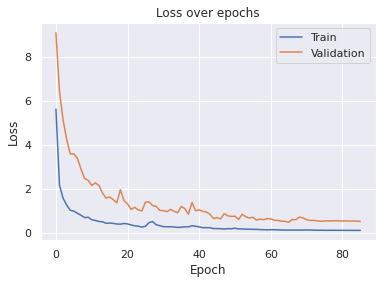

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### **RMSE Score**

In [0]:
model.load_weights("best_model_5.h5")

In [0]:
predictions = model.predict([X_temporal_valid,X_demographic_valid])

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# [X_temporal_valid,X_demographic_valid],  [Y_cases_valid, Y_fatalities_valid]
print("Confirmed cases RMSE Score", sqrt(mean_squared_error(Y_cases_valid,predictions[0])))
print("Death cases RMSE Score", sqrt(mean_squared_error(Y_fatalities_valid,predictions[1])))

Confirmed cases RMSE Score 19989.60609917064
Death cases RMSE Score 1932.212333052452


### **Sample Output**

In [0]:
display_limit = 20
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_valid,predictions[0][:display_limit], Y_cases_valid[:display_limit], predictions[1][:display_limit], Y_fatalities_valid[:display_limit]):
    print("================================================")
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

Expected cases: 555.0  Prediction: 574.21063 Expected fatalities: 18.0  Prediction: 18.962938
Expected cases: 840.0  Prediction: 1027.9631 Expected fatalities: 30.0  Prediction: 42.95794
Expected cases: 433.0  Prediction: 594.2339 Expected fatalities: 23.0  Prediction: 36.788757
Expected cases: 518.0  Prediction: 701.37415 Expected fatalities: 26.0  Prediction: 40.670174
Expected cases: 1825.0  Prediction: 6623.278 Expected fatalities: 275.0  Prediction: 1040.1638
Expected cases: 2268.0  Prediction: 6623.505 Expected fatalities: 348.0  Prediction: 1035.4607
Expected cases: 601.0  Prediction: 851.8743 Expected fatalities: 26.0  Prediction: 43.612045
Expected cases: 673.0  Prediction: 872.1835 Expected fatalities: 33.0  Prediction: 46.577293
Expected cases: 19.0  Prediction: 21.95654 Expected fatalities: 2.0  Prediction: 1.9358951
Expected cases: 19.0  Prediction: 21.457556 Expected fatalities: 2.0  Prediction: 1.9044373
Expected cases: 21.0  Prediction: 22.528328 Expected fatalities: 2.

### **Prediction from 17th April to 15th May**

In [0]:
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=sequence_length)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")

    province_df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    temporal_input_data = np.transpose(np.reshape(np.asarray([province_df["ConfirmedCases"],
                                                 province_df["Fatalities"],
                                                #  df["restrictions"],
                                                 province_df["quarantine"],
                                                 province_df["schools"]]),
                                     (4,sequence_length)), (1,0) ).astype(np.float32)
    
    temp = province_df[province_df['Date']==str_end_date]
    total_population = float(temp.total_pop)
    density = float(temp.density)
    hospibed = float(temp.hospibed)
    lung = float(temp.lung)
    centenarian_pop = float(temp["age_100+"])
    smokers_perc = float(temp.smokers_perc)
    demographic_input_data = [total_population,density,hospibed,lung,centenarian_pop, smokers_perc]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [0]:
def predict_for_region(country, province, df, startDate, endDate):
    start_date = datetime.strptime(startDate,"%Y-%m-%d")
    end_date = datetime.strptime(endDate,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        # "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][2]) else 0,
                        "schools": 1 if any(input_data[0][0][3]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "age_100+": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [0]:
copy_df = merge_dataset.query("Date>'2020-01-22'and Date<'2020-04-01'")
startDate='2020-03-18'
endDate='2020-04-15'
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df, startDate, endDate)
        pbar.update(1)